In [1]:
from stage1 import *

In [2]:
nframes,natoms,nmols=(0,0,0)

In [3]:
from stage2 import * 

In [4]:
stage1

VGAE(
  (encoder): VariationalGCNEncoder(
    (conv1): GATConv(5, 15, heads=3)
    (head_transform1): Linear(45, 15, bias=True)
    (bn1): BatchNorm(15)
    (conv2): GCNConv(15, 9)
    (bn2): BatchNorm(9)
    (linear1): Linear(9, 100, bias=True)
    (linear2): Linear(100, 4, bias=True)
    (transform): Linear(16, 3, bias=True)
    (mu): Linear(3, 3, bias=True)
    (logstd): Linear(3, 3, bias=True)
  )
  (decoder): VariationalGCNDecoder(
    (inv_transform): Linear(3, 4, bias=True)
    (conv1): GCNConv(1, 9)
    (bn1): BatchNorm(9)
    (conv2): GCNConv(9, 3)
    (bn2): BatchNorm(3)
    (conv3): GCNConv(3, 3)
    (linear1): Linear(3, 512, bias=True)
    (linear2): Linear(512, 128, bias=True)
    (linear3): Linear(128, 5, bias=True)
  )
)

In [5]:
testframe=md.load_xtc("../../xtc_files/50000eql2.xtc",top="../../xtc_files/conf.gro",frame=0)


In [6]:
cf=condenseframe(testframe)

In [7]:
meltframes=md.load_xtc("../../xtc_files/50000eql2.xtc",top="../../xtc_files/conf.gro")
meltframes.xyz=meltframes.xyz*10
global nframes,natoms,nmols 
nframes = meltframes.xyz.shape[0]
natoms = meltframes.topology.residue(0).n_atoms
nmols = meltframes.topology.n_residues
print (nframes,natoms,nmols)
meltframes=meltframes[::1000]

50001 4 592


In [8]:
cf

array([[ 9.89732184e+02, -1.19746289e+02, -1.97409429e+02,
         2.28225017e+00,  9.52250063e-01,  1.95350003e+00],
       [ 9.89768499e+02, -1.19735860e+02, -1.97410766e+02,
         1.36549997e+00,  1.45650005e+00,  2.59900022e+00],
       [ 9.89681805e+02, -1.19738573e+02, -1.97401416e+02,
         8.33750010e-01,  1.77175009e+00,  7.37500072e-01],
       ...,
       [ 9.89936113e+02, -1.19777279e+02, -1.97450172e+02,
         2.56474996e+00,  1.57500005e+00,  2.47574997e+00],
       [ 9.89917252e+02, -1.19778816e+02, -1.97441199e+02,
         1.61825013e+00,  1.92200017e+00,  2.49900007e+00],
       [ 9.89954919e+02, -1.19774158e+02, -1.97441629e+02,
         7.91500092e-01,  2.24175000e+00,  2.16525006e+00]])

In [9]:
melt_condensed=condenseAllFrames(meltframes)
graphs_melt_cpu=get_graphs(melt_condensed,"melt")
print(len(graphs_melt_cpu))

100%|██████████| 51/51 [00:02<00:00, 18.11it/s]

30192


In [10]:
torch.save(graphs_melt_cpu,f'./graphs/melt_neigh{n_neigh}.pt')

In [11]:
g = get_graph(cf,1,n_neigh,"cry")

In [12]:
graphs_cpu=graphs_melt_cpu
np.random.shuffle(graphs_cpu)


In [13]:
import os
in_channels = graphs_cpu[0].num_features
out_channels = 5
lr = 1e-4
n_epochs = 500
batch_size=32
test_train_split = 0.8
model_name = "Interex1.pt"
model_loaded = False
force_train = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if os.path.exists("./"+model_name) and not force_train:
    model = torch.load("./"+model_name)
    model_loaded = True
else:
    model = VGAE_S2(VariationalGCNEncoder_S2(in_channels, out_channels,batch_size,n_neigh+1),
                    VariationalGCNDecoder_S2(out_channels, in_channels,batch_size,n_neigh+1))

model = model.to(device)
model = model.double()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=300, gamma=0.5)


In [14]:
graphs_device = []
for graph in tqdm(graphs_cpu):
    graphs_device.append(graph.to(device))

100%|██████████| 30192/30192 [00:17<00:00, 1689.73it/s]


In [15]:
graphs = graphs_device
total_graphs = len(graphs)


In [16]:
print("Using:",device )
print("total_graphs:", total_graphs)
print("batch Size:" , batch_size)
print("number of batches:",total_graphs//batch_size)
print("Neighbours:",n_neigh)
print("Model\n",model)

Using: cuda
total_graphs: 30192
batch Size: 32
number of batches: 943
Neighbours: 20
Model
 VGAE_S2(
  (encoder): VariationalGCNEncoder_S2(
    (conv1): GATConv(6, 15, heads=3)
    (head_transform1): Linear(45, 15, bias=True)
    (bn1): BatchNorm(15)
    (conv2): GCNConv(15, 9)
    (bn2): BatchNorm(9)
    (linear1): Linear(9, 100, bias=True)
    (linear2): Linear(100, 4, bias=True)
    (transform): Linear(84, 5, bias=True)
    (mu): Linear(5, 5, bias=True)
    (logstd): Linear(5, 5, bias=True)
  )
  (decoder): VariationalGCNDecoder_S2(
    (inv_transform): Linear(5, 21, bias=True)
    (conv1): GCNConv(1, 9)
    (bn1): BatchNorm(9)
    (conv2): GCNConv(9, 3)
    (bn2): BatchNorm(3)
    (conv3): GCNConv(3, 3)
    (linear1): Linear(3, 512, bias=True)
    (linear2): Linear(512, 128, bias=True)
    (linear3): Linear(128, 6, bias=True)
  )
)


In [17]:
split = int(test_train_split * total_graphs)
train_loader = DataLoader(graphs[:split], batch_size=batch_size, shuffle=True)
test_loader = DataLoader(graphs[split:], batch_size=batch_size, shuffle=True)

In [18]:
cross_entropy_loss = torch.nn.CrossEntropyLoss()
MSE_loss = torch.nn.MSELoss()

def train():
    model.train()
    model.zero_grad()
    all_loss_mse = 0
    for data in train_loader:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)
        loss = MSE_loss(decoded_x, data.x)
        loss.backward()
        all_loss_mse += float(loss)
        optimizer.step()


    return all_loss_mse/len(train_loader)

In [19]:
def test():
    model.eval()
    model.zero_grad()
    all_loss_mse = 0
    for data in test_loader:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)

        loss = MSE_loss(decoded_x, data.x)

        all_loss_mse += float(loss)


    return all_loss_mse/len(test_loader)

In [20]:
train_losses = []
test_losses = []

if model_loaded:
    print("Pretrained Model Loaded, no training required")
else:
    for epoch in range(1, n_epochs + 1):

        train_loss_mse = train()
        test_loss_mse = test()

        print(f"Epoch: {epoch:03d}")
        print(f'\tTrain:\tMSE Loss: {train_loss_mse:.4f}')
        print(f'\tTest: \tMSE Loss: {test_loss_mse:.4f}')

        train_losses.append([train_loss_mse]);
        test_losses.append([test_loss_mse]);

        scheduler.step()
    torch.save(model,"./models/"+model_name)

Epoch: 001
	Train:	MSE Loss: 125970.7898
	Test: 	MSE Loss: 55801.4584
Epoch: 002
	Train:	MSE Loss: 32828.2670
	Test: 	MSE Loss: 26359.9598
Epoch: 003
	Train:	MSE Loss: 21506.4986
	Test: 	MSE Loss: 17109.1377
Epoch: 004
	Train:	MSE Loss: 14204.6632
	Test: 	MSE Loss: 11200.1809
Epoch: 005
	Train:	MSE Loss: 9619.8460
	Test: 	MSE Loss: 8264.1195
Epoch: 006
	Train:	MSE Loss: 7623.9153
	Test: 	MSE Loss: 7287.7394
Epoch: 007
	Train:	MSE Loss: 6972.3697
	Test: 	MSE Loss: 6779.2471
Epoch: 008
	Train:	MSE Loss: 6493.1812
	Test: 	MSE Loss: 6219.5955
Epoch: 009
	Train:	MSE Loss: 5753.6296
	Test: 	MSE Loss: 5213.0858
Epoch: 010
	Train:	MSE Loss: 4259.4985
	Test: 	MSE Loss: 3118.7221
Epoch: 011
	Train:	MSE Loss: 1791.1335
	Test: 	MSE Loss: 837.1234
Epoch: 012
	Train:	MSE Loss: 427.9821
	Test: 	MSE Loss: 240.2148
Epoch: 013
	Train:	MSE Loss: 161.6067
	Test: 	MSE Loss: 105.2091
Epoch: 014
	Train:	MSE Loss: 80.5734
	Test: 	MSE Loss: 56.7925
Epoch: 015
	Train:	MSE Loss: 50.4881
	Test: 	MSE Loss: 40.3405

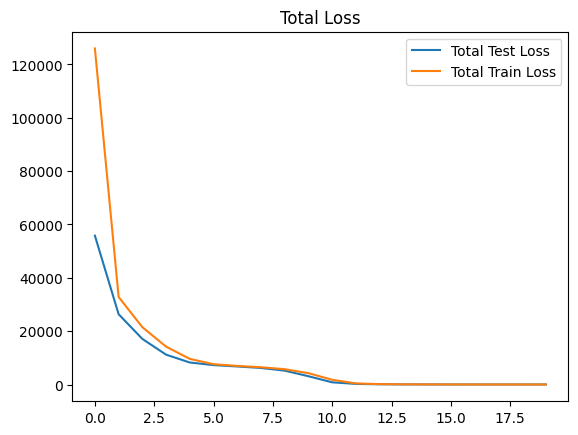

In [21]:
if not model_loaded:
    plt.figure()
    plt.plot(test_losses, label='Total Test Loss')
    plt.plot(train_losses, label='Total Train Loss')
    plt.legend()
    plt.title('Total Loss')
    plt.show()

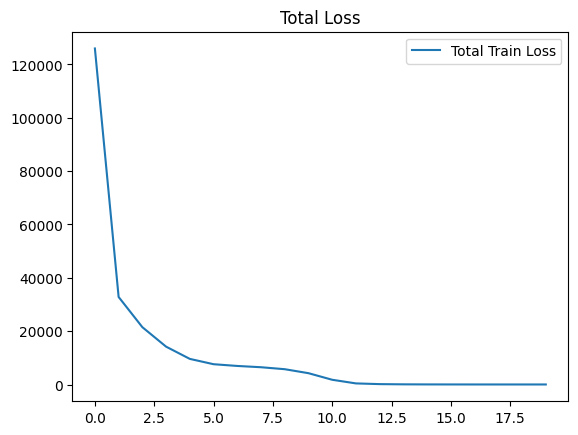

In [22]:
if not model_loaded:
    plt.figure()
    # plt.plot(test_losses, label='Total Test Loss')
    plt.plot(train_losses, label='Total Train Loss')
    plt.legend()
    plt.title('Total Loss')
    plt.show()

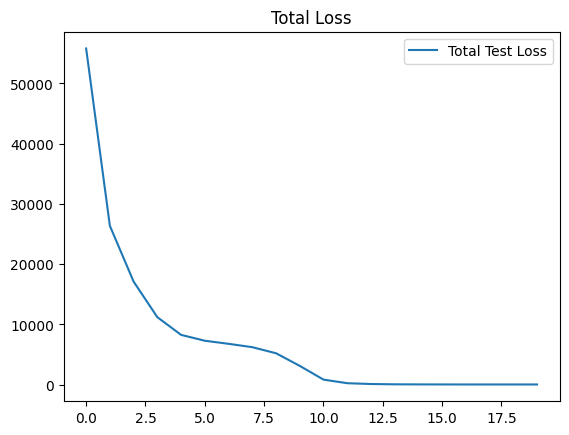

In [23]:
if not model_loaded:
    plt.figure()
    plt.plot(test_losses, label='Total Test Loss')
    # plt.plot(train_losses, label='Total Train Loss')
    plt.legend()
    plt.title('Total Loss')
    plt.show()

In [24]:
from torch.functional import F

avg1 = 0
avg2 = 0

embeddings = []
input_feature = []
decoded_feature = []

for ind in range(len(test_loader)):
    test_graph = test_loader.dataset[ind]

    model.double()
    z,encoded_edge_index = model.encode(test_graph.x,test_graph.edge_index)
    decoded_x,decoded_edge_index = model.decode(z,encoded_edge_index)
    heavy_indices = torch.where(test_graph.x[:,4] > torch.tensor([1]).to(device))

    embeddings.append(z)
    decoded_feature.append(decoded_x)
    input_feature.append(test_graph.x)
    
    Error_wo_s = F.mse_loss(decoded_x[heavy_indices], test_graph.x[heavy_indices]).detach().cpu().numpy()



    avg1 += Error_wo_s

print("Average Error", avg1/len(test_loader))


Average Error 28.05779505862935


In [25]:
np.set_printoptions(suppress=True)
heavy_indices = torch.where(input_feature[0][:,4] > torch.tensor([1]).to(device))
heavy_indices
# decoded_feature[0][heavy_indices],input_feature[0][heavy_indices]
len(input_feature[0][heavy_indices])

21

In [26]:
decoded_feature[0][heavy_indices]

tensor([[ 990.0506, -123.4682, -203.7530,   12.2899,   16.7106,   11.1423],
        [ 988.7469, -119.1113, -196.3212,   12.4931,   16.4542,   11.1554],
        [ 989.1320, -119.1976, -196.4659,   12.4915,   16.4635,   11.1615],
        [ 989.1106, -119.1911, -196.4550,   12.4917,   16.4629,   11.1612],
        [ 988.7527, -119.1124, -196.3232,   12.4931,   16.4544,   11.1555],
        [ 988.7553, -119.1130, -196.3241,   12.4931,   16.4544,   11.1555],
        [ 988.9098, -119.1445, -196.3769,   12.4926,   16.4580,   11.1581],
        [ 989.1345, -119.1984, -196.4673,   12.4915,   16.4636,   11.1616],
        [ 988.7446, -119.1108, -196.3204,   12.4931,   16.4542,   11.1553],
        [ 988.7484, -119.1116, -196.3217,   12.4931,   16.4543,   11.1554],
        [ 989.3710, -119.3013, -196.6414,   12.4878,   16.4724,   11.1640],
        [ 989.3339, -119.2815, -196.6078,   12.4885,   16.4708,   11.1637],
        [ 989.3148, -119.2714, -196.5906,   12.4889,   16.4699,   11.1636],
        [ 98

In [27]:
input_feature[0][heavy_indices]

tensor([[ 989.9702, -119.7174, -197.4461,   17.7350,   10.4075,   13.6400],
        [ 986.9079, -119.3819, -196.9609,   20.1525,    9.8200,   14.9100],
        [ 987.3854, -119.4173, -196.8317,   16.2525,   12.4750,   14.7975],
        [ 989.1010, -119.7790, -197.3123,   19.4800,   10.5975,   11.3325],
        [ 988.4413, -119.4549, -197.2279,   16.6425,    7.7425,   14.1175],
        [ 989.2933, -119.8192, -197.3148,   19.0025,    8.0400,   10.6400],
        [ 989.5766, -119.8400, -197.3905,   16.4150,   11.7475,    9.9300],
        [ 988.2301, -119.4109, -197.1076,   18.9575,   14.3825,   14.2825],
        [ 989.4200, -119.5783, -197.3722,   19.0750,    9.8500,   17.6350],
        [ 988.3251, -119.6736, -197.1814,   21.6900,   12.1025,   14.7650],
        [ 989.0167, -119.4743, -197.1589,   17.1400,    7.9025,   17.4000],
        [ 988.7663, -119.5247, -197.3156,   14.3200,    8.3075,   15.9900],
        [ 987.6838, -119.3698, -196.9224,   13.8425,   12.9850,   13.2550],
        [ 98

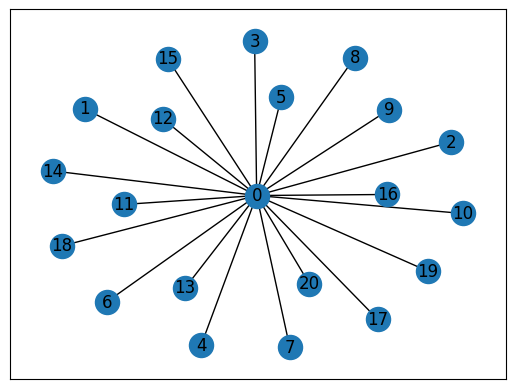

In [28]:
add_self_loops=False
adj_binary = convert_to_adj(decoded_edge_index, num_nodes=decoded_x.shape[0])
indices = torch.where(adj_binary)
G = nx.Graph()
if not add_self_loops:
    edges = [(i, j) for i, j in zip(indices[0].tolist(), indices[1].tolist()) if i != j]
    G.add_edges_from(edges)
else:
    G.add_edges_from(zip(indices[0].tolist(), indices[1].tolist()))
nx.draw_networkx(G)
plt.show()
